# 1. Import Libraries:

In [ ]:
!pip uninstall transformers accelerate -y

In [1]:
!pip install transformers[torch]
!pip install accelerate -U

In [2]:
!pip install wordcloud lazypredict
!pip install transformers
!pip install torch

In [3]:
import pandas as pd
from sklearn.utils import resample
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from lazypredict.Supervised import LazyClassifier, LazyRegressor
import pickle
import time

import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries for bert
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. Load Dataset (Centralized)

## Dataset 3

In [61]:
df3 = pd.read_csv('AHSD-davidson-2019/labeled_data.csv')
df3.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [62]:
#useful cols:
df3 = df3[['class','tweet']]
df3.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [63]:
# renaming the selected cols:
# Before renaming the columns
print("\nBefore modifying column names:\n", df3.columns)

df3.rename(columns = {'class':'label','tweet':'tweet'}, inplace = True)

# After renaming the columns
print("\nAfter modifying first column:\n", df3.columns)


Before modifying column names:
 Index(['class', 'tweet'], dtype='object')

After modifying first column:
 Index(['label', 'tweet'], dtype='object')


In [64]:
# Filter out offensive language rows
df3 = df3[df3['label'] != 1]

# Map the labels
df3['label'] = df3['label'].map({0: 1, 2: 0})

In [65]:
# splitting the dataset into Train and Test:
train3, test3 = train_test_split(df3, test_size=0.3,random_state=10, shuffle=True)

train3 = train3[['label','tweet']]
test3 = test3[['label','tweet']]

print("Training Set 3 :"% train3.columns, train3.shape)
print("Test Set 3 :"% test3.columns, test3.shape)
print('Train Set 3 -----')
print(train3.isnull().sum())
print('Test Set 3 -----')
print(test3.isnull().sum())
train3.head()

Training Set 3 : (3915, 2)
Test Set 3 : (1678, 2)
Train Set 3 -----
label    0
tweet    0
dtype: int64
Test Set 3 -----
label    0
tweet    0
dtype: int64


,label,tweet
8363,0,Can't tell if Mexico has been impressive or if...
4306,1,@NyJusDntGAF just like a nig to come home when...
5542,0,@ashley_smith20 colored contacts
21439,0,That was not good times! Starting the mickey m...
15026,0,RT @DonnieWahlberg: On set of #BlueBloods. Hop...


In [66]:
train = pd.concat([train3], ignore_index = True)
train.shape

(111780, 2)

In [67]:
train['label'].value_counts()

label
0    101040
1     10740
Name: count, dtype: int64

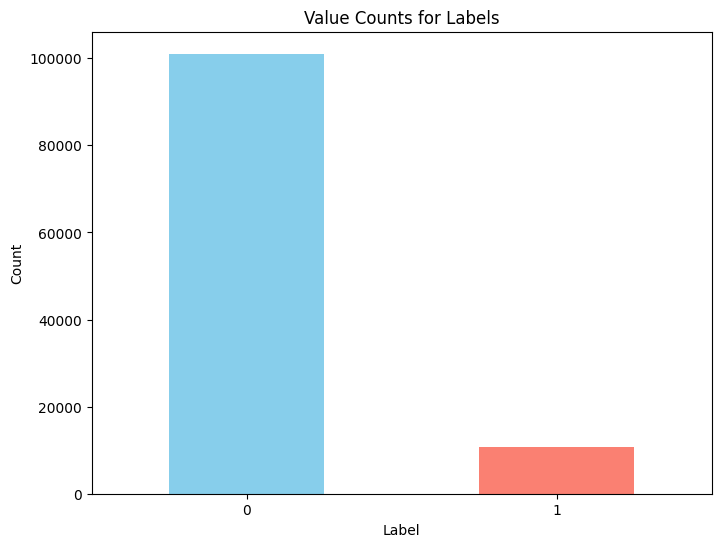

In [68]:
# Assuming you have a DataFrame named 'train' with a column 'label'
label_counts = train['label'].value_counts()

# Plotting the value counts
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Value Counts for Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [69]:
# Merging 3 Test Data Sets
test = pd.concat([test3], ignore_index = True)
print(test.shape)
test.head()

(1678, 2)


,label,tweet
0,0,&#8220;@iamkrause: All I see in every #IfTheyG...
1,0,RT @SportsCenter: A WILD one in the Bronx.\nYa...
2,0,Someone probably told him 6 God was trash.
3,1,"Playing to white guilt lasted one last time, w..."
4,1,@davidly62793584 how many fuckin fags did a ev...


# 3. Data Analysis and Cleaning

In [70]:
# Clean Data:
def  clean_text(df, text_field):
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))
    return df

test_clean = clean_text(test, "tweet")
train_clean = clean_text(train, "tweet")

In [71]:
# upsampled
train_majority = train_clean[train_clean.label==0]
train_minority = train_clean[train_clean.label==1]
# train_minority_upsampled = resample(train_minority,
#                                  replace=True,
#                                  n_samples=len(train_majority),
#                                  random_state=123)
# train_upsampled = pd.concat([train_minority_upsampled, train_majority])
train_upsampled = pd.concat([train_minority, train_majority])
train_upsampled['label'].value_counts()

label
1    101040
0    101040
Name: count, dtype: int64

In [72]:
print(train_clean.shape)
# train_clean
print(train_upsampled.shape)
# train_upsampled

(111780, 2)
(202080, 2)


# 4. Visualizing the Data


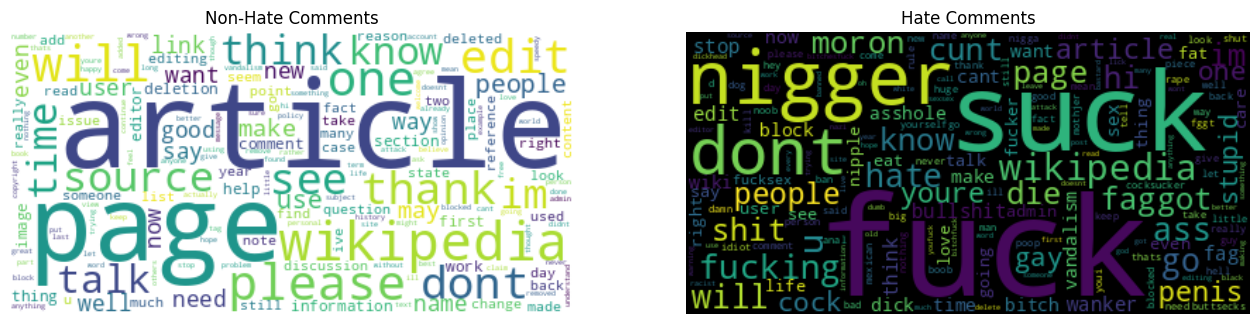

In [ ]:
fig, axs = plt.subplots(1,2 , figsize=(16,8))
text_pos = " ".join(train_clean['tweet'][train.label == 0])
text_neg = " ".join(train_clean['tweet'][train.label == 1])
train_cloud_pos = WordCloud(collocations = False, background_color = 'white').generate(text_pos)
train_cloud_neg = WordCloud(collocations = False, background_color = 'black').generate(text_neg)
axs[0].imshow(train_cloud_pos, interpolation='bilinear')
axs[0].axis('off')
axs[0].set_title('Non-Hate Comments')
axs[1].imshow(train_cloud_neg, interpolation='bilinear')
axs[1].axis('off')
axs[1].set_title('Hate Comments')

plt.show()

<Figure size 1000x600 with 0 Axes>

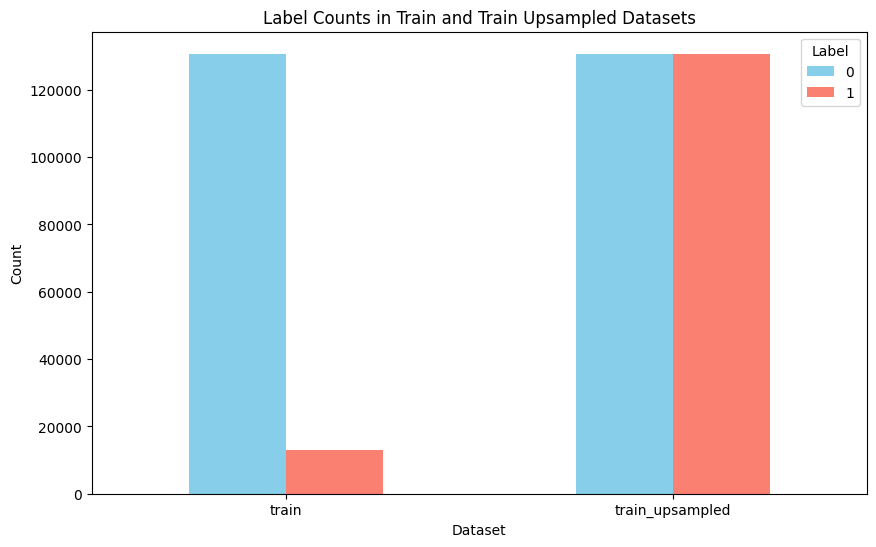

In [ ]:
# Counting the labels
train_clean_counts = train_clean['label'].value_counts()
train_upsampled_counts = train_upsampled['label'].value_counts()

# Creating a DataFrame to hold the counts
counts_df = pd.DataFrame({
    'train': train_clean_counts,
    'train_upsampled': train_upsampled_counts
}).transpose()

# Plotting
plt.figure(figsize=(10, 6))
counts_df.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'salmon'])
plt.title('Label Counts in Train and Train Upsampled Datasets')
plt.xlabel('Dataset')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Label')
plt.show()


--------------After Upsampling the Minority Class---------------


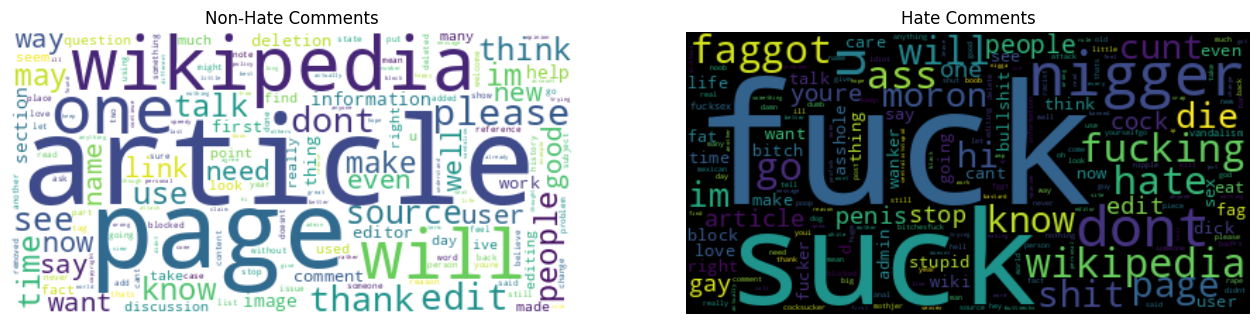

In [ ]:
print('--------------After Upsampling the Minority Class---------------')
fig, axs = plt.subplots(1,2 , figsize=(16,8))
text_pos = " ".join(train_upsampled['tweet'][train.label == 0])
text_neg = " ".join(train_upsampled['tweet'][train.label == 1])
train_cloud_pos = WordCloud(collocations = False, background_color = 'white').generate(text_pos)
train_cloud_neg = WordCloud(collocations = False, background_color = 'black').generate(text_neg)
axs[0].imshow(train_cloud_pos, interpolation='bilinear')
axs[0].axis('off')
axs[0].set_title('Non-Hate Comments')
axs[1].imshow(train_cloud_neg, interpolation='bilinear')
axs[1].axis('off')
axs[1].set_title('Hate Comments')

plt.show()

# 5. Bert Model Fine-Tuning and Split-Data

For our BERT-based model, we employed _Tiny-BERT_, a compact version of the BERT model. _Tiny-Bert_ has a total of $4$ million parameters and $2$ hidden layers with $128$ hidden dimension. Tiny-Bert is $7x$ smaller and $9x$ faster than BERT while achieving $96\%$ of its performance. 
We used the _BertTokenizer_ and _BertForSequenceClassification_ from the Hugging Face library, pretrained on the _prajjwal1/bert-tiny_ model with $2$ output labels for binary classification. The model was trained using the Trainer API from Hugging Face's Transformers library, with a training configuration that included $5$ epochs, a batch size of $16$, $10$ warmup steps, $0.01$ as weight decay, and logging every $10$ steps. The training was performed on a GPU.


In [73]:
# Load the tokenizer and model from Huggingface prajjwal1/bert-tiny

# base-bert
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2) # we can also use GPT/ lamma

# tiny-bert
tokenizer = BertTokenizer.from_pretrained('prajjwal1/bert-tiny')
model = BertForSequenceClassification.from_pretrained('prajjwal1/bert-tiny', num_labels=2) # we can also use GPT/ lamma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [74]:
# Create a custom dataset class
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [75]:
# Assuming train_upsampled is your DataFrame containing the tweets and labels
x = train_upsampled['tweet'].tolist()
y_hate = train_upsampled['label'].tolist()

x_test = test_clean['tweet'].tolist()
y_test_hate = test_clean['label'].tolist()

## Train & Test splitting the Data

In [76]:
# Split the dataset into train and validation sets
x_train, x_val, y_train, y_val = train_test_split(x, y_hate, test_size=0.3, random_state=42)

# Create the dataset objects
train_dataset = HateSpeechDataset(x_train, y_train, tokenizer, max_len=128)
validation_dataset = HateSpeechDataset(x_val, y_val, tokenizer, max_len=128)
test_dataset = HateSpeechDataset(x_test, y_test_hate, tokenizer, max_len=128)

# 6. Train Model

In [52]:
import transformers
import accelerate

print(f"Transformers version: {transformers.__version__}")
print(f"Accelerate version: {accelerate.__version__}")

Transformers version: 4.41.2
Accelerate version: 0.30.1


In [77]:
# Import necessary libraries
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=10,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='epoch'
)

# Check if GPU is available and move the model to the GPU if it is
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer
)

# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.199800,0.938616
2,0.108200,1.083669
3,0.100200,1.006929


Epoch,Training Loss,Validation Loss
1,0.199800,0.938616
2,0.108200,1.083669
3,0.100200,1.006929
4,0.003500,1.183642
5,0.055000,1.217836


TrainOutput(global_step=44205, training_loss=0.11088953742068718, metrics={'train_runtime': 2013.0244, 'train_samples_per_second': 351.352, 'train_steps_per_second': 21.959, 'total_flos': 224647518412800.0, 'train_loss': 0.11088953742068718, 'epoch': 5.0})

In [54]:
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
# Check if GPU is available and move the model to the GPU if it is
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Prepare the validation data for evaluation
val_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


# Perform evaluation
model.eval()
preds = []
true_labels = []

with torch.no_grad():
    for batch in val_loader:
        # Move batch tensors to the same device as the model
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        inputs = {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels
        }

        outputs = model(**inputs)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        preds.extend(predictions.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Compute metrics
accuracy = accuracy_score(true_labels, preds)
f1 = f1_score(true_labels, preds, average='weighted')
conf_matrix = confusion_matrix(true_labels, preds)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.9189511323003575
F1 Score: 0.9196385086431106
Confusion Matrix:
[[1161   80]
 [  56  381]]
